In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

from skopt.utils import use_named_args
import logging

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_parquet("./dataset.parquet")\
    .dropna(subset=['month_purchase'])

df.loc[:, 'has_second_sale_within_month'] = (
    (df.loc[:, 'has_second_sale_within_year'] == 1) & 
    (df.loc[:, 'waiting_time'] <= 30)
)

categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
feature_columns = [
    'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
    'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 'fst_sale_in_black_friday_days', 
    'snd_sale_in_black_friday_days'
]

In [4]:
df.has_second_sale_within_month.value_counts()

True     256913
False    179542
Name: has_second_sale_within_month, dtype: int64

In [5]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [6]:
features = [c for c in df.columns if any([c.startswith(x) for x in feature_columns])]
X = df.loc[:, features].values
y = df.loc[:, 'has_second_sale_within_month'].astype(int).values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
HYPERPARAMETER_SPACE = [
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 1.0, "uniform", name='learning_rate'),
    Real(0.1, 10, "log-uniform", name='gamma'),    
    Real(0.05, 1, name='subsample'),
    Real(0.05, 1, name='colsample_bytree'),
    Integer(2, 10, name='max_depth'),
    Integer(2, 200, name="n_estimators"),
    Real(0.01, 0.99, name="base_score"),
    Real(0, 500, name="scale_pos_weight"),
    Real(0, 5, name="reg_alpha"),
    Real(0, 5, name="reg_lambda"),
]

HYPERPARAMETER_NAMES = [dim.name for dim in HYPERPARAMETER_SPACE]

In [9]:
RANDOM_STATE = 939568576
TREE_METHOD = 'exact'
NUM_PROCESSORS = 4
NUM_CROSS_VALIDATION_STEPS = 1
NUM_GP_OPTIMIZATION_STEPS = 1

In [10]:
def get_logger(name):
    logger = logging.getLogger(name)
    formatter = logging.Formatter('[%(levelname)s] %(asctime)s: %(name)s - %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)
    return logger

In [11]:
def train_model(X, y, **kwargs):
    model = XGBClassifier(
        random_state=RANDOM_STATE,
        tree_method=TREE_METHOD,
        n_jobs=NUM_PROCESSORS,
        **kwargs,
    )
    model.fit(X, y)
    return model

def evaluate_model(X, y, **kwargs):
    roc_auc = []
    for _ in range(NUM_CROSS_VALIDATION_STEPS):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        model = train_model(X_train, y_train, **kwargs)
        score = model.predict_proba(X_test)[:, 1]
        roc_auc.append(skmetrics.roc_auc_score(y_test, score))
    return np.mean(roc_auc)


def train_optimized_model(X, y):
    
    logger = get_logger(__name__)
    
    @use_named_args(HYPERPARAMETER_SPACE)
    def loss(**kwargs):
        return -evaluate_model(X, y, **kwargs)

    def get_optimization_callback():
        message = "Hyperparameter optimization iteration {:d}/{:d}. Current: {:5.3f}. Best: {:5.3f}. Parameters:\n{}"
        def callback(res):          
            current_value = -res.func_vals[-1]
            best_value = -res.func_vals.min()            
            current_params = pd.Series(dict(zip(
                HYPERPARAMETER_NAMES, 
                map(fix_type, res.x)
            )))
            logger.info(message.format(
                len(res.func_vals),
                NUM_GP_OPTIMIZATION_STEPS,
                current_value,
                best_value,
                current_params
            ))

        return callback

    def fix_type(x):
        if isinstance(x, bool):
            return x
        elif np.issubdtype(np.dtype(x), np.int_):
            return int(x)
        elif np.issubdtype(np.dtype(x), np.float_):
            return float(x)

    logger.info("Will start hyperparameter optimization.")
    optimization_results = gp_minimize(
        loss,
        HYPERPARAMETER_SPACE,
        n_random_starts=max(1, min(10, int(NUM_GP_OPTIMIZATION_STEPS / 2))),
        n_calls=NUM_GP_OPTIMIZATION_STEPS,
        random_state=RANDOM_STATE,
        callback=get_optimization_callback(),
    )
    logger.info("Finished hyperparameter optimization.")
    best_parameters = dict(
        zip(HYPERPARAMETER_NAMES, map(fix_type, optimization_results.x))
    )
    logger.info("Starting training of final model.")
    return train_model(X, y, verbosity=1, **best_parameters)


In [12]:
%time best_model = train_optimized_model(X_train, y_train)

[INFO] 2019-04-17 16:46:51,010: __main__ - Will start hyperparameter optimization.
[INFO] 2019-04-17 16:47:00,435: __main__ - Hyperparameter optimization iteration 1/1. Current: 0.735. Best: 0.735. Parameters:
min_child_weight     3.000000
learning_rate        0.316840
gamma                1.260333
subsample            0.784180
colsample_bytree     0.268833
max_depth            6.000000
n_estimators        84.000000
base_score           0.613412
scale_pos_weight     5.992884
reg_alpha            4.715997
reg_lambda           1.309442
dtype: float64
[INFO] 2019-04-17 16:47:00,436: __main__ - Finished hyperparameter optimization.
[INFO] 2019-04-17 16:47:00,436: __main__ - Starting training of final model.


CPU times: user 1min 18s, sys: 316 ms, total: 1min 18s
Wall time: 20.2 s


In [13]:
y_pred = best_model.predict(X_test)
print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.01      0.02     53847
           1       0.59      1.00      0.74     77090

   micro avg       0.59      0.59      0.59    130937
   macro avg       0.73      0.51      0.38    130937
weighted avg       0.71      0.59      0.45    130937



In [14]:
s_pred = best_model.predict_proba(X_test)[:, 1]

In [15]:
skmetrics.roc_auc_score(y_test, s_pred)

0.7417211329873513

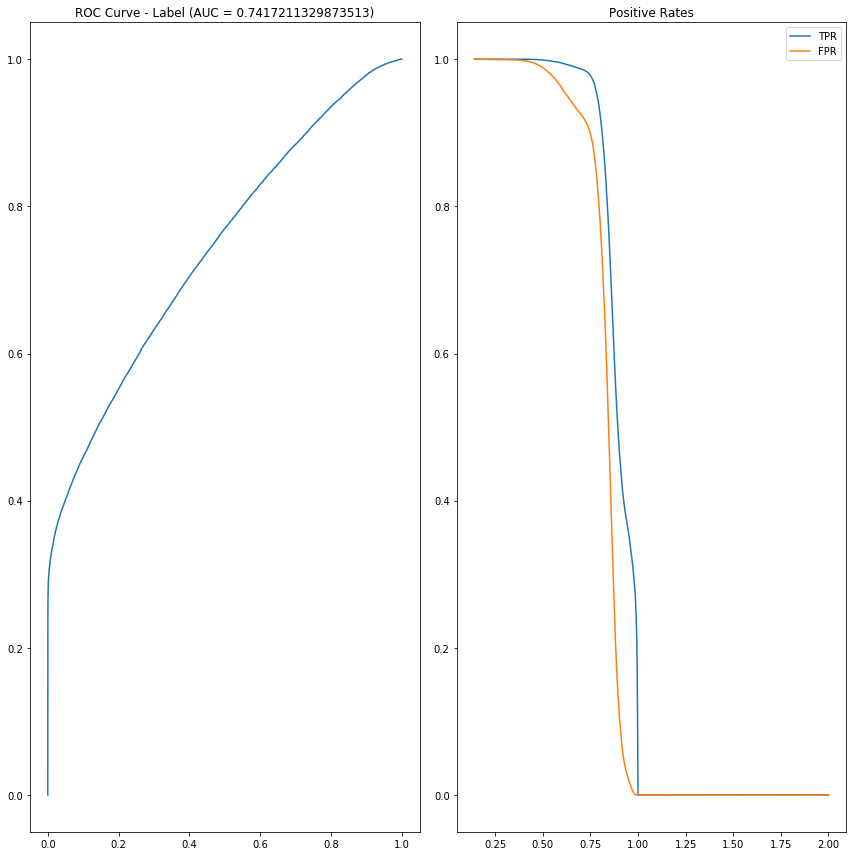

In [17]:
fig = plt.figure(figsize=(12, 12))

roc_auc = skmetrics.roc_auc_score(y_test, s_pred)
fpr, tpr, roc_thres = skmetrics.roc_curve(y_test, s_pred)

ax = fig.add_subplot(1, 2, 1)
ax.set_title(f"ROC Curve - Label (AUC = {roc_auc})")
ax.plot(fpr, tpr)

ax = fig.add_subplot(1, 2, 2)
ax.set_title(f"Positive Rates")
ax.plot(roc_thres, tpr, label="TPR")
ax.plot(roc_thres, fpr, label="FPR")
ax.legend()

fig.tight_layout()

In [18]:
n_points = 100

thresholds = np.linspace(s_pred.min(), s_pred.max()*0.999, n_points)

metrics = pd.DataFrame([
    np.array(skmetrics.precision_recall_fscore_support(y_test, (s_pred >= threshold), average=None))[:, 0]
    for threshold in thresholds
], columns=["precision", "recall", "f1", "support"], index=thresholds)

metrics.head()

/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,f1,support
0.139934,0.0,0.000000,0.000000,53847.0
0.148611,1.0,0.000056,0.000111,53847.0
0.157288,1.0,0.000074,0.000149,53847.0
0.165965,1.0,0.000074,0.000149,53847.0
0.174642,1.0,0.000093,0.000186,53847.0


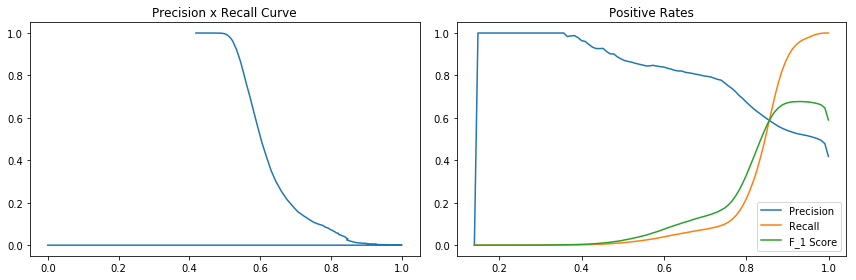

In [19]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_title("Precision x Recall Curve")
ax.plot(metrics.precision, metrics.recall)

ax = fig.add_subplot(122)
ax.set_title("Positive Rates")
ax.plot(metrics.index, metrics.precision, label="Precision")
ax.plot(metrics.index, metrics.recall, label="Recall")
ax.plot(metrics.index, metrics.f1, label="F_1 Score")
ax.legend()

fig.tight_layout()

In [20]:
optimal_threshold = metrics.f1.argmax()
print(metrics.loc[optimal_threshold])
y_pred = (s_pred > optimal_threshold).astype(int)

precision        0.523214
recall           0.959162
f1               0.677084
support      53847.000000
Name: 0.9295413232210911, dtype: float64


/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [21]:
print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.96      0.68     53847
           1       0.93      0.39      0.55     77090

   micro avg       0.62      0.62      0.62    130937
   macro avg       0.73      0.67      0.61    130937
weighted avg       0.76      0.62      0.60    130937



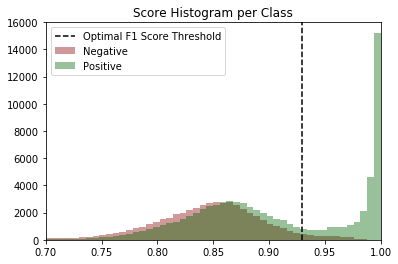

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
bins = np.linspace(0.7, 1, 51)
sns.distplot(s_pred[y_test == 0], bins=bins, label="Negative", ax=ax, color="DarkRed", kde=False)
sns.distplot(s_pred[y_test == 1], bins=bins, label="Positive", ax=ax, color="DarkGreen", kde=False)
ax.axvline(optimal_threshold, color='k', ls='--', label="Optimal F1 Score Threshold")
ax.set_title("Score Histogram per Class")
ax.set_xlim(0.7, 1.0)
ax.legend()